In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
# check cuda

import platform
print(platform.python_version())

3.10.12


In [3]:
import torch

Man I should make some video utils...

* processing
    * text
    * video
    * img

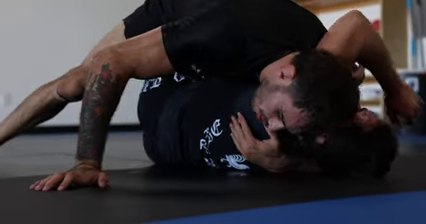

In [4]:
from processing import video

clip_filename = "/home/rocus/Documents/john/grepl/clips/Szj2-YS3J2o_115.mp4"

img = video.get_frame_from_timestamp(clip_filename, 10)
display(img)

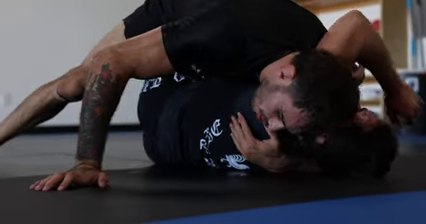

In [5]:
frames = [
    video.get_frame_from_timestamp(clip_filename, t)
    for t in range(0, 60)
]
display(frames[10])

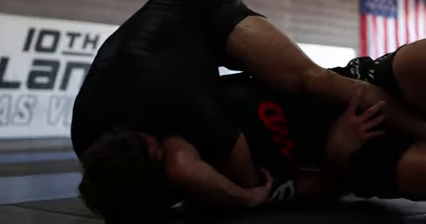

In [6]:
display(frames[27])

# Get DINO activations

In [7]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output

In [8]:
dinov2_vits14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dino = dinov2_vits14_reg

Using cache found in /home/rocus/.cache/torch/hub/facebookresearch_dinov2_main
/home/rocus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/rocus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/rocus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [10]:
dino = dinov2_vits14_reg
type(dino)

dinov2.models.vision_transformer.DinoVisionTransformer

In [29]:
dinov2_vits14_reg

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [14]:
from PIL import Image
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino = dino.to(device)

def get_dino_activations(image: Image.Image) -> torch.Tensor:
    """
    Get DINO activations for a given image.

    Args:
        image (Image.Image): Input image.

    Returns:
        torch.Tensor: DINO activations.
    """

    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size expected by the model
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # Normalization values for ImageNet
            std=[0.229, 0.224, 0.225]
        )
    ])
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Move the tensor to the same device as the model
    input_tensor = input_tensor.to(device)

    # Perform a forward pass
    with torch.no_grad():
        activations = dino(input_tensor)

    # `activations` now contains the output of the model
    return activations

In [15]:
activations = []
for frame in frames:
    activations.append(get_dino_activations(frame))

In [16]:
len(activations)

60

In [17]:
stacked_activations = torch.cat(activations, dim=0)
stacked_activations.shape

torch.Size([60, 384])

In [18]:
dot_products = torch.matmul(stacked_activations, stacked_activations.T)

In [19]:
dot_products.cpu().numpy()

array([[529.4602 , 478.40558, 452.4004 , ..., 402.58145, 400.52524,
        399.23947],
       [478.40558, 514.49054, 480.61444, ..., 426.57837, 407.47583,
        415.2116 ],
       [452.4004 , 480.61444, 516.9184 , ..., 427.26886, 405.60303,
        413.77747],
       ...,
       [402.58145, 426.57837, 427.26886, ..., 603.09125, 564.6422 ,
        557.7706 ],
       [400.52524, 407.47583, 405.60303, ..., 564.6422 , 621.88074,
        573.13245],
       [399.23947, 415.2116 , 413.77747, ..., 557.7706 , 573.13245,
        603.0829 ]], dtype=float32)

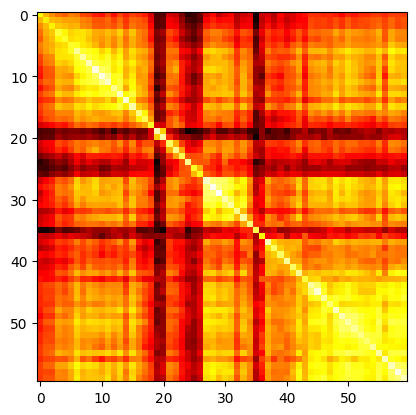

In [ ]:
# heatmap of dot_products (square matrix)
import matplotlib.pyplot as plt
plt.imshow(dot_products.cpu().numpy(), cmap="hot")

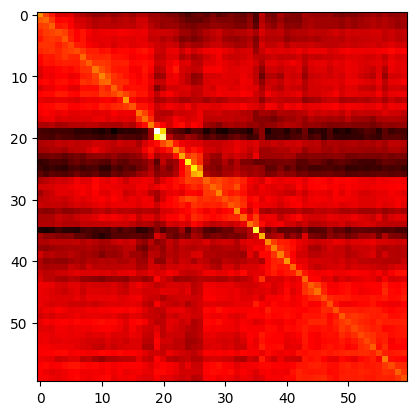

In [24]:
dot_products_normed = dot_products.cpu().numpy()

dot_products_normed /= dot_products_normed.mean(axis=0, keepdims=True)
plt.imshow(dot_products_normed, cmap="hot")

In [ ]:
activations[0].shape[0]

960